In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm import tqdm
#import utils
import ampds_preprocessing
from time import time
import pickle
%load_ext autoreload
%autoreload 2


Bad key "text.kerning_factor" on line 4 in
/clusteruy/home/cmarino/miniconda3/envs/mine/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [35]:
with open('arrays/df.pickle', 'rb') as fp:
    df = pickle.load(fp)
# divide los dataframes entre agregados y desagregados
individual = df.loc[:, df.columns.get_level_values('name')!='WHE']
aggregate = df.loc[:, df.columns.get_level_values('name')=='WHE']

In [28]:
D = np.load('arrays/D.npy')
X = np.load('arrays/X.npy')

# Problema a resolver
Se intenta resolver un problema similar al del paper https://arxiv.org/pdf/1704.07308.pdf. El problema es el siguiente:
$$min_A ||X - DA||_{F}^2$$

$$\text{ s.t. $A_{i,j}>0$ $\forall i,j$}$$

- $D$ (Matriz de diccionario): Es una matriz cuyas columnas son las bases del consumo de energeia electrico (se espera poder estimar el consumo sea una combinación lineal de estos vectores).

- $X$ (Matriz de datos a proyectar): Es una matriz en la que cada columna representa el consumo electrico de que se quiere proyectar sobre las columnas de $D$.

## Implementación
Se implementa mediante apgd. El tipo de aceleración que se elige es ADAM.

In [12]:
names = list(ampds_preprocessing.FULL_NAME.keys())
names.remove('WHE')
sum_current_elec = np.empty((len(names), X.shape[1]))
mask = np.zeros(D.shape[1], dtype=int)
for i, s in enumerate(names):
    # Mascara para tener solo el electrodomestico de interes
    mask[(individual.columns.get_level_values('name')==s)[0:D.shape[1]]] = i
n_mask = len(names)

In [14]:
from apgd import adam_pgd
t1 = time()
A_s2k, cost, losses_s2k = adam_pgd(D, X, mask=mask, n_mask=n_mask, 
                                   early_stopping=50)
t2 = time()
print(f'Tiempo: {t2-t1:.1f}')

[iter:0]	36890960.00
Tiempo: 0.8


In [17]:
len(losses_s2k)

61

In [29]:
losses_s2k = np.array(losses_s2k)
np.save('arrays/A_s2k.npy', A_s2k)
np.save('arrays/losses_s2k.npy', losses_s2k)

In [30]:
from utils import plot_loss

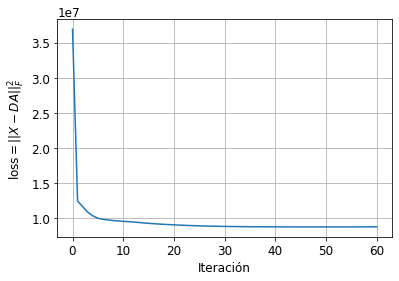

In [34]:
plot_loss(losses_s2k)